# ATP Tennis Match Prediction Project

## Introduction
Welcome to the ATP Tennis Match Prediction project! This notebook showcases a comprehensive machine learning workflow designed to predict the outcomes of ATP (Association of Tennis Professionals) tennis matches using historical data spanning from 2000 to 2024. Built as a portfolio piece, this project demonstrates proficiency in data preprocessing, feature engineering, and predictive modeling, with a focus on delivering actionable insights for tennis enthusiasts and data scientists alike.

The dataset is sourced from Jeff Sackmann's `tennis_atp` repository on GitHub, which provides detailed match, ranking, and player information. By transforming raw tennis statistics into meaningful predictive features and employing a Gradient Boosting Classifier optimized with Bayesian search, this project achieves robust performance while respecting the temporal nature of the data.

## Objectives
The primary goal is to predict the winner of a tennis match as a binary classification problem (Player 1 wins = 0, Player 2 wins = 1). To achieve this, the project:
- Cleans and preprocesses historical ATP match data.
- Engineers advanced features such as win rates, serve statistics, break point performance, head-to-head records, and player form indicators.
- Trains and optimizes a machine learning model using time-series cross-validation to ensure temporal consistency.
- Evaluates the model's performance on a test set covering recent years (2022-2024).

This work not only highlights technical skills but also reflects a deep understanding of tennis dynamics, making it a compelling case study for sports analytics.

## Dataset
The project leverages the following datasets from the `tennis_atp` repository:
- **Matches**: Annual CSV files (`atp_matches_YYYY.csv`) from 1968 to 2024, containing match details such as player IDs, scores, rankings, and serve statistics. However in this notebook, I will only use 2000 to 2024 for computational problems.
- **Rankings**: Decade-based CSV files (`atp_rankings_YYs.csv`) for historical player rankings.
- **Players**: A single CSV file (`atp_players.csv`) with player metadata (e.g., height, hand, date of birth).

The training set covers 2000-2021, and testing uses 2022-2024, ensuring a realistic evaluation on recent data.

## Methodology
The workflow is structured as follows:

### 1. Data Loading and Preprocessing
- **Loading**: Custom functions aggregate match, ranking, and player data across multiple years.
- **Cleaning**: Missing values are handled strategically (e.g., height imputed with 0 and flagged, ranks imputed with KNN).
- **Target Balancing**: To avoid bias where "winner" is always Player 1, the dataset is randomly flipped (50% chance of swapping Player 1 and Player 2), creating a balanced target variable (`winner`: 0 or 1).

### 2. Feature Engineering
A robust pipeline generates predictive features, ensuring no data leakage by excluding current match data from historical calculations:
- **Win Rates**: Overall, surface-specific, and rolling win rates adjusted with a Bayesian approach to stabilize estimates for players with few matches.
- **Serve Statistics**: First serve percentage, win percentages on first/second serves, aces, and double faults per match.
- **Break Point Performance**: Save and conversion rates, reflecting pressure-handling ability.
- **Head-to-Head (H2H)**: Historical win-loss records between opponents.
- **Player Form**: Recent game counts and ranking point changes over time.
- **Categorical Encoding**: One-hot encoding for tournament levels, surfaces, and rounds.

### 3. Modeling
- **Pipeline**: A scikit-learn `Pipeline` integrates feature selection (`VarianceThreshold`, `SelectKBest`), standardization (`StandardScaler`), and a `GradientBoostingClassifier`.
- **Optimization**: Bayesian search (`BayesSearchCV`) tunes hyperparameters over a time-series split (5 folds) to maximize accuracy while respecting match chronology.
- **Evaluation**: Cross-validation scores and test accuracy assess model performance.


In [57]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer # Added SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder # Added MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

# Download Data

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Adjust paths if using Google Drive
    DRIVE_PATH = '/content/drive/MyDrive/ATP/'
except ImportError:
    print("Google Colab environment not detected. Using relative paths.")
    # Define alternative base path if not in Colab
    DRIVE_PATH = './' # Or specify the correct local path

np.random.seed(42)

pd.set_option('display.max_columns', None)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Define paths using the base path
# Assuming the 'tennis_atp-master' directory is within DRIVE_PATH
BASE_TENNIS_PATH = DRIVE_PATH + 'tennis_atp-master/'
MATCH_PATH = BASE_TENNIS_PATH + "atp_matches_"
RANKINGS_PATH = BASE_TENNIS_PATH + "atp_rankings_"
PLAYERS_PATH = BASE_TENNIS_PATH + "atp_players.csv"

def load_match(start, end):
    """
    This function load the matches from start to end, from the atp matches files
    """
    dataset = []
    for i in range(start, end+1):
        path = MATCH_PATH + f"{i}.csv"
        df = pd.read_csv(path)
        dataset.append(df)
    dataset = pd.concat(dataset, ignore_index=True)
    return dataset

date_rankings=[0,1,2,7,8,9]
def load_rankings():
    """
    This function load the rankings from date_rankings
    """
    dataset = []
    for i in date_rankings:
        path = RANKINGS_PATH + f"{i}0s.csv"
        df = pd.read_csv(path)
        dataset.append(df)
    dataset = pd.concat(dataset, ignore_index=True)
    return dataset

def load_players():
    """
    This function loads the players from the atp_players files
    """
    df = pd.read_csv(PLAYERS_PATH)
    return df

In [6]:
# --- Load Rankings/Players (Optional, uncomment if needed) ---
# def load_rankings(): ... (as before)
# def load_players(): ... (as before)

# --- Initial Data Loading ---
print("--- Starting Data Loading ---")
full_dataset = load_match(2010, 2024)

print(f"Shape of raw dataset: {full_dataset.shape}")

print("\n--- End of Loading ---")

--- Starting Data Loading ---
Shape of raw dataset: (42571, 49)

--- End of Loading ---


In [7]:
print(f"Shape of dataset : {full_dataset.shape}")

test_data = full_dataset.copy()
test_data = test_data.drop(['winner_seed', 'loser_seed', 'winner_entry', 'loser_entry', 'loser_ht', 'winner_ht'], axis=1)
num_rows_with_nan = test_data.isna().any(axis=1).sum()
print(f"Number of rows with at least 1 NaN value = {num_rows_with_nan}")

for col in test_data.columns:
    print(f"Colonne problématique : {col:<20} | Nombre de NaN : {test_data[col].isna().sum():>10} => {(test_data[col].isna().mean()*100):.1f}%")

Shape of dataset : (42571, 49)
Number of rows with at least 1 NaN value = 4744
Colonne problématique : tourney_id           | Nombre de NaN :          0 => 0.0%
Colonne problématique : tourney_name         | Nombre de NaN :          0 => 0.0%
Colonne problématique : surface              | Nombre de NaN :         53 => 0.1%
Colonne problématique : draw_size            | Nombre de NaN :          0 => 0.0%
Colonne problématique : tourney_level        | Nombre de NaN :          0 => 0.0%
Colonne problématique : tourney_date         | Nombre de NaN :          0 => 0.0%
Colonne problématique : match_num            | Nombre de NaN :          0 => 0.0%
Colonne problématique : winner_id            | Nombre de NaN :          0 => 0.0%
Colonne problématique : winner_name          | Nombre de NaN :          0 => 0.0%
Colonne problématique : winner_hand          | Nombre de NaN :          0 => 0.0%
Colonne problématique : winner_ioc           | Nombre de NaN :          0 => 0.0%
Colonne problématiq

# Feature Engineering

In [8]:
def flip_dataset(df):
    """
    This function transforms the original dataset by randomly swapping winner/loser
    information to create a balanced dataset for predicting match outcomes.
    """
    print("Flip dataset starting ...")

    df_flipped = df.copy()

    # Create a random mask with 50% probability of True for each row.
    # This mask determines which rows will have their winner/loser data swapped.
    flip_mask = np.random.rand(len(df_flipped)) > 0.5

    # Create a 'winner' column indicating the outcome after the potential swap.
    # 1: Player 2 wins (winner/loser data swapped)
    # 0: Player 1 wins (winner/loser data remains as is)
    df_flipped["winner"] = np.where(flip_mask, 1, 0)

    # Itera through columns to swap winner/loser columns based on the flip mask
    for col in df_flipped.columns:
        if col.startswith("winner_"):
            loser_col = "loser_" + col[len("winner_"):]
            if loser_col in df_flipped.columns:
                temp = df_flipped.loc[flip_mask, col].copy()
                df_flipped.loc[flip_mask, col] = df_flipped.loc[flip_mask, loser_col]
                df_flipped.loc[flip_mask, loser_col] = temp

    # Rename the columns to player1 and player2
    rename_dict = {}
    for col in df_flipped.columns:
        if col.startswith("winner_"):
            rename_dict[col] = "player1_" + col[len("winner_"):]
        elif col.startswith("w_"):
            rename_dict[col] = "player1_" + col[len("w_"):]
        elif col.startswith("loser_") :
            rename_dict[col] = "player2_" + col[len("loser_"):]
        elif col.startswith("l_"):
            rename_dict[col] = "player2_" + col[len("l_"):]

    # Apply the column renaming to the dataframe.
    df_flipped = df_flipped.rename(columns=rename_dict)

    print("Flip dataset ended.")
    return df_flipped

In [9]:
# Dictionary mapping tournament rounds to the number of days since the tournament start date.
# This is used to estimate the actual match date based on the tournament start date and the round.
round_to_days = {
    "R128": 0,  # Round of 128 (first round), assumed to be on the tournament start date.
    "R64":  1,  # Round of 64, assumed to be 1 day after the tournament start date.
    "R32":  2,  # Round of 32, assumed to be 2 days after the tournament start date.
    "R16":  3,  # Round of 16, assumed to be 3 days after the tournament start date.
    "QF":   4,  # Quarterfinals, assumed to be 4 days after the tournament start date.
    "SF":   5,  # Semifinals, assumed to be 5 days after the tournament start date.
    "F":    6,  # Final, assumed to be 6 days after the tournament start date.
    "RR":   0,  # Round Robin, no date adjustment.
    "ER":   0,  # Early Round, no date adjustment.
    "BR":   0   # Bronze Round, no date adjustment.
}


def transform_date(df):
    """
    Transforms the tournament date and round information to estimate the actual match date.
    """
    # Map the 'round' column to the number of days since the tournament start using the 'round_to_days' dictionary.
    df["round_day"] = df["round"].map(round_to_days)

    # Add the 'round_day' (as a timedelta) to the 'tourney_date' to estimate the 'match_date'.
    df["match_date"] = df["tourney_date"] + pd.to_timedelta(df["round_day"], unit="d")

    return df

In [10]:
def process_dataset(df):
    """
    Processes the tennis match dataset to prepare it for further analysis.

    This function performs the following steps:
    1. Converts the 'tourney_date' column to datetime format.
    2. Estimates the actual match date using the 'transform_date' function.
    3. Sorts the dataset by match date.
    4. Creates a unique 'match_id' column.
    """
    # Ensure the 'tourney_date' column is in datetime format.
    df["tourney_date"] = pd.to_datetime(df["tourney_date"], format='%Y%m%d', errors="coerce")

    # Estimate the actual match date using the 'transform_date' function.
    df = transform_date(df)

    # Sort the dataset by match date in ascending order.
    df = df.sort_values('match_date')

    # Create a unique 'match_id' column by resetting the index.
    df = df.reset_index(drop=True)  # Reset index to consecutive integers.
    df['match_id'] = df.index  # Assign the index as 'match_id'.

    return df  # Return the processed dataframe.

In [11]:
def calculate_number_of_games(score, bestof):
    """
    Calculates the total number of games played in a tennis match based on the score string.
    """
    # Remove any text within parentheses (e.g., tiebreak scores) from the score string.
    score = re.sub(r'\(.*?\)', '', score)

    total_games = 0
    sets = score.split()

    # Iterate through each set score:
    for set_score in sets:
        # Split the set score by '-' to get the games won by each player.
        # Convert the game scores to integers and sum them to get the total games in the set.
        games = sum([int(x) for x in set_score.split('-') if x.isdigit()])
        total_games += games

    # Return the total number of games played.
    return total_games

In [12]:
class ServeStatsImputerV2(BaseEstimator, TransformerMixin):
    """
    Imputes serve stats using historical player data, then historical surface data.
    Calculates historical stats dynamically during transform to avoid data leakage.
    """
    def __init__(self, strategy='median', default_fill_value=0):
        # Validate strategy
        if strategy not in ['mean', 'median']:
            raise ValueError("Strategy must be either 'mean' or 'median'")
        self.strategy = strategy
        self.default_fill_value = default_fill_value
        self.base_stats_cols = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
        self.player1_stats_cols = [f'player1_{col}' for col in self.base_stats_cols]
        self.player2_stats_cols = [f'player2_{col}' for col in self.base_stats_cols]
        self.all_stats_cols = self.player1_stats_cols + self.player2_stats_cols

    def fit(self, X, y=None):
        # No fitting needed as calculations are historical and done in transform
        # print("ServeStatsImputerV2: No fitting required.")
        return self

    def transform(self, X):
        X_transformed = X.copy()

        # 1. Reshape to long format for easier historical calculation
        df1 = X_transformed[['match_id', 'match_date', 'player1_id', 'surface'] + self.player1_stats_cols].rename(columns={'player1_id': 'player_id'})
        df1.columns = [col.replace('player1_', '') if col.startswith('player1_') else col for col in df1.columns]
        df1['role'] = 'player1'

        df2 = X_transformed[['match_id', 'match_date', 'player2_id', 'surface'] + self.player2_stats_cols].rename(columns={'player2_id': 'player_id'})
        df2.columns = [col.replace('player2_', '') if col.startswith('player2_') else col for col in df2.columns]
        df2['role'] = 'player2'

        df_long = pd.concat([df1, df2], ignore_index=True)

        # Sort chronologically for expanding calculations
        df_long = df_long.sort_values(by=['match_date', 'match_id', 'player_id']).reset_index(drop=True) # Ensure stable sort

        # 2. Calculate Historical Stats (Player and Surface) using Expanding Window
        # Choose aggregation function based on strategy
        agg_func = self.strategy # 'mean' or 'median'

        # Calculate historical stats dynamically to avoid leakage
        # Group by player, shift data by 1 to exclude current match, then calculate expanding agg
        gb_player = df_long.groupby('player_id')[self.base_stats_cols]
        # shift(1) ensures we only use past data for the expanding calculation
        historical_player_stats_df = gb_player.shift(1).expanding().agg(agg_func)
        historical_player_stats_df.columns = [f'{col}_player_hist' for col in self.base_stats_cols]

        # Group by surface, shift, calculate expanding agg
        # Note: Surface history is less common, might result in many NaNs initially
        gb_surface = df_long.groupby('surface')[self.base_stats_cols]
        historical_surface_stats_df = gb_surface.shift(1).expanding().agg(agg_func)
        historical_surface_stats_df.columns = [f'{col}_surface_hist' for col in self.base_stats_cols]

        # Combine historical stats back with the long dataframe
        # Indices should align due to sorting and standard pandas operations
        df_long = pd.concat([df_long, historical_player_stats_df, historical_surface_stats_df], axis=1)

        # 3. Impute Missing Values Sequentially
        # print("  Imputing missing values sequentially...")
        for col in self.base_stats_cols:
            player_hist_col = f'{col}_player_hist'
            surface_hist_col = f'{col}_surface_hist'

            # Check if the original column exists before trying to fillna
            if col in df_long.columns:
                # Fill NaNs in original stat column first with player history, then surface history
                # Use .loc to avoid potential SettingWithCopyWarning if df_long was sliced
                df_long.loc[:, col] = df_long[col].fillna(df_long[player_hist_col])
                df_long.loc[:, col] = df_long[col].fillna(df_long[surface_hist_col])
                # Fill any remaining NaNs with the default value
                df_long.loc[:, col] = df_long[col].fillna(self.default_fill_value)
            else:
                print(f"Warning: Original column '{col}' not found during imputation.")


            # Clean up historical columns (optional, saves memory)
            if player_hist_col in df_long.columns:
                 df_long = df_long.drop(columns=[player_hist_col])
            if surface_hist_col in df_long.columns:
                 df_long = df_long.drop(columns=[surface_hist_col])


        # 4. Reshape back to wide format (player1_stat, player2_stat)
        # print("  Reshaping back to wide format...")

        # Select relevant columns before pivoting
        # Ensure 'surface' is kept if needed, though it's usually dropped later
        cols_to_keep_long = ['match_id', 'role'] + self.base_stats_cols
        df_long_final_stats = df_long[cols_to_keep_long]

        # Pivot the statistics columns
        try:
            df_pivot = df_long_final_stats.pivot(index='match_id', columns='role', values=self.base_stats_cols)
            # Flatten MultiIndex columns (e.g., ('ace', 'player1') -> 'player1_ace')
            df_pivot.columns = [f'{role}_{stat}' for stat, role in df_pivot.columns]
            df_pivot = df_pivot.reset_index() # Bring match_id back as a column
        except Exception as e:
            print(f"Error during pivoting: {e}")
            print("Check for duplicate match_id/role combinations if error persists.")
            # Handle error, maybe return original X or raise
            raise e


        # 5. Merge imputed stats back into the original DataFrame structure
        # Drop original (potentially unimputed) stats columns first
        X_transformed = X_transformed.drop(columns=self.all_stats_cols, errors='ignore')
        # Merge based on match_id
        X_transformed = X_transformed.merge(df_pivot, on='match_id', how='left')

        # Verify columns after merge
        final_cols_present = [col for col in self.all_stats_cols if col in X_transformed.columns]
        if len(final_cols_present) != len(self.all_stats_cols):
             missing_final_cols = set(self.all_stats_cols) - set(final_cols_present)
             print(f"Warning: Some stats columns might be missing after merge/pivot: {missing_final_cols}")

        # print("ServeStatsImputerV2: Transformation complete.")
        return X_transformed

In [13]:
# OK
def impute_surface(df):
    """
    Imputes missing surface values using the mode.
    """

    print("Imputing missing surface values...")

    df["surface"] = df["surface"].fillna(df["surface"].mode()[0])

    print("Missing values surfaces imputed.")
    return df

In [14]:
# OK
def minutes_Imputer(df):
    """
    Imputes missing minutes using MEDIAN based on Number of Games
    """
    print("Imputing missing minutes with median...")

    # Calculate helper features if needed
    if 'numberofGames' not in df.columns or 'numberofSets' not in df.columns:
        print("Calculating helper features for minutes imputation...")
        if 'score' not in df.columns: print("Error: 'score' column needed."); return df
        if 'best_of' not in df.columns: print("Warning: 'best_of' column missing, defaulting to 3."); df['best_of'] = 3

        print("Compute number of games and sets...")
        df["numberofGames"] = df.apply(lambda row: calculate_number_of_games(row['score'], row['best_of']), axis=1)
        df["numberofSets"] = df["score"].apply(lambda x: len(re.sub(r'\(.*?\)', '', str(x)).split()) if pd.notna(x) and str(x) not in ['W/O', 'RET', 'Def.', 'Walkover', 'Default'] else 0)
        print("number of games/sets ok.")

    # Impute 'minutes' based on median per number of games
    imputation_values_by_games = df.groupby('numberofGames')['minutes'].transform("median")
    imputation_values_by_set = df.groupby('numberofSets')['minutes'].transform("median")

    # Check if 'minutes' column has missing values
    if df['minutes'].isnull().any():
        df['minutes'] = df['minutes'].fillna(imputation_values_by_games)
        df['minutes'] = df['minutes'].fillna(imputation_values_by_set)

    if df['minutes'].isna().sum() > 0:
      print("ERROR MISSING VAL")
    # Optionally drop helper columns if not needed later (keep if used in delete_Features_v2)
    # df = df.drop(columns=['numberofGames', 'numberofSets'], errors='ignore')
    print("Minutes Imputed OK")
    return df

In [17]:
#OK
def get_minutes_played_recent(df, date_window=14):
  """
  Calculates the total minutes played by each player in recent matches.
  Determined by the date_window parameter.
  """
  print("Start get_minutes_played_recent...")

  df_test = pd.concat([
      df[['match_id', 'match_date', 'player1_id', 'minutes']].rename(columns={'player1_id': 'player_id'}).assign(role='player1'),
      df[['match_id', 'match_date', 'player2_id', 'minutes']].rename(columns={'player2_id': 'player_id'}).assign(role='player2')
  ])

  df_test = df_test.sort_values(['player_id', 'match_id']).reset_index(drop=True)

  window = f"{date_window}D"
  df_test["minutes_played_recently"] = (df_test.groupby('player_id')
        .apply(lambda x: x.set_index('match_date')['minutes'].rolling(window).sum().values)
        .explode().reset_index(drop=True))
  df_test["minutes_played_recently"] = (df_test["minutes_played_recently"] - df_test["minutes"]).astype(int)

  # Extract stats
  player1_stats = df_test[df_test['role'] == 'player1'][['match_id', 'minutes_played_recently']].copy()
  player2_stats = df_test[df_test['role'] == 'player2'][['match_id', 'minutes_played_recently']].copy()

  player1_stats = player1_stats.rename(columns={'minutes_played_recently': 'player1_minutes_played_recently'})
  player2_stats = player2_stats.rename(columns={'minutes_played_recently': 'player2_minutes_played_recently'})

  df = df.merge(player1_stats, on='match_id', how='left').merge(player2_stats, on='match_id', how='left')

  print("End get_minutes_played_recent...")
  return df

In [18]:
#OK
def elo_feature(df, k_factor=32, initial_elo=1500):
  """
  Creates and add Elo ratings features for each player, both globally and per surface.
  """
  print("Calculating Elo features...")

  global_elo = {}
  surface_elo = {}

  # df_test = df[['match_date', 'match_id', 'player1_id', 'player2_id', 'surface']].copy()
  df = df.sort_values(by=['match_date', 'match_id']).reset_index(drop=True)

  player1_elo = []
  player2_elo = []
  player1_elo_surface = []
  player2_elo_surface = []

  for idx, row in df.iterrows():
        p1_id = row['player1_id']
        p2_id = row['player2_id']
        surface = row['surface']
        winner = row['winner']

        if p1_id not in global_elo:
            global_elo[p1_id] = initial_elo
        if p2_id not in global_elo:
            global_elo[p2_id] = initial_elo

        if p1_id not in surface_elo:
            surface_elo[p1_id] = {}
        if p2_id not in surface_elo:
            surface_elo[p2_id] = {}
        if surface not in surface_elo[p1_id]:
            surface_elo[p1_id][surface] = initial_elo
        if surface not in surface_elo[p2_id]:
            surface_elo[p2_id][surface] = initial_elo

        p1_elo = global_elo[p1_id]
        p2_elo = global_elo[p2_id]
        p1_elo_surface = surface_elo[p1_id][surface]
        p2_elo_surface = surface_elo[p2_id][surface]

        player1_elo.append(p1_elo)
        player2_elo.append(p2_elo)
        player1_elo_surface.append(p1_elo_surface)
        player2_elo_surface.append(p2_elo_surface)

        expected_p1 = 1 / (1 + 10 ** ((p2_elo - p1_elo) / 400))
        expected_p1_surface = 1 / (1 + 10 ** ((p2_elo_surface - p1_elo_surface) / 400))

        result = 1 if winner == 0 else 0

        global_elo[p1_id] += k_factor * (result - expected_p1)
        global_elo[p2_id] += k_factor * (expected_p1 - result)

        surface_elo[p1_id][surface] += k_factor * (result - expected_p1_surface)
        surface_elo[p2_id][surface] += k_factor * (expected_p1_surface - result)

  df['player1_elo'] = player1_elo
  df['player2_elo'] = player2_elo
  df['player1_elo_surface'] = player1_elo_surface
  df['player2_elo_surface'] = player2_elo_surface
  df['elo_diff'] = df['player1_elo'] - df['player2_elo']
  df['elo_surface_diff'] = df['player1_elo_surface'] - df['player2_elo_surface']

  print("Elo features calculated")
  return df#, df_test

In [19]:
# OK
def get_h2h_v2(df, date_window=5):
    """
    Calculate weighted head-to-head statistics with exponential decay for older matches.
    Also compute the number of matches played between the two players.
    """
    # Select relevant columns for H2H calculation.
    df_h2h = df[['match_id', 'match_date', 'player1_id', 'player2_id', 'surface', 'winner']].copy()

    # Create a standardized player pair identifier, regardless of column order.
    df_h2h['player_pair'] = df_h2h.apply(
        lambda row: tuple(sorted([row['player1_id'], row['player2_id']])),
        axis=1
    )

    # Define the match outcome relative to the standardized player pair order.
    def outcome(row):
        pair = row['player_pair']
        if row['player1_id'] == pair[0]:
            return 1 if row['winner'] == 0 else 0
        else:
            return 1 if row['winner'] == 1 else 0

    df_h2h['outcome'] = df_h2h.apply(outcome, axis=1)

    # Sort matches by date to establish chronological order.
    df_h2h = df_h2h.sort_values('match_date').reset_index(drop=True)

    # Calculate the cumulative number of matches for each player pair.
    df_h2h['cum_matches'] = df_h2h.groupby('player_pair').cumcount()

    # Calculate the cumulative wins for the first player in the pair prior to the current match.
    df_h2h['cum_wins_first'] = df_h2h.groupby('player_pair')['outcome'].transform(
        lambda s: s.cumsum().shift(1, fill_value=0)
    )

    # MODIFIED SECTION - Calculate recent wins and match counts
    # First create shifted outcomes column
    df_h2h['shifted_outcome'] = df_h2h.groupby('player_pair')['outcome'].shift(1)

    # Calculate rolling stats
    df_h2h['recent_cum_wins_first'] = df_h2h.groupby('player_pair')['shifted_outcome'].transform(
        lambda x: x.rolling(window=date_window, min_periods=0).sum()
    )
    df_h2h['recent_matches_count'] = df_h2h.groupby('player_pair')['shifted_outcome'].transform(
        lambda x: x.rolling(window=date_window, min_periods=0).count()
    )

    # Clean up temporary column
    df_h2h = df_h2h.drop(columns=['shifted_outcome'])

    # Calculate the head-to-head record as the difference between the first player's wins
    # and the second player's wins.
    df_h2h['historical_h2h'] = 2 * df_h2h['cum_wins_first'] - df_h2h['cum_matches']

    # Calculate recent H2H performance
    df_h2h['recent_h2h'] = 2 * df_h2h['recent_cum_wins_first'] - df_h2h['recent_matches_count']
    df = df.merge(df_h2h[['match_id', 'historical_h2h', 'recent_h2h']], on='match_id', how='left')

    return df#, df_h2h

In [20]:
# ok
def serve_stats_rating(df, date_window=365, default_fill=0.5):
    """
    Calculates rolling serve stats and combines them into ratings.
    """
    print("Calculating serve stats ratings (Refactored)...")

    X = df.copy()
    stats_cols = [
        'player1_ace', 'player1_df', 'player1_svpt', 'player1_1stIn', 'player1_1stWon', 'player1_2ndWon', 'player1_SvGms', 'player1_bpSaved', 'player1_bpFaced',
        'player2_ace', 'player2_df', 'player2_svpt', 'player2_1stIn', 'player2_1stWon', 'player2_2ndWon', 'player2_SvGms', 'player2_bpSaved', 'player2_bpFaced'
    ]
    base_stats_cols = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']

    # Create long format
    df_long = pd.concat([
            X[['match_id', 'match_date', 'player1_id', 'surface'] + [col for col in stats_cols if 'player1' in col]]
            .rename(columns={'player1_id': 'player_id'})
            .rename(columns=lambda x: x.replace('player1_', '') if 'player1_' in x else x)
            .assign(role='player1'),
            X[['match_id', 'match_date', 'player2_id', 'surface'] + [col for col in stats_cols if 'player2' in col]]
            .rename(columns={'player2_id': 'player_id'})
            .rename(columns=lambda x: x.replace('player2_', '') if 'player2_' in x else x)
            .assign(role='player2')
        ])

    df_long = df_long.sort_values(['player_id', 'match_date', 'match_id']).reset_index(drop=True)
    df_long = df_long.set_index('match_date')
    window = f"{date_window}D"

    # Compute the number of match played globally and by surface
    df_long["cum_matches"] = df_long.groupby('player_id')['player_id'].transform(lambda x: x.rolling(window, closed='left').count() - 1)
    df_long["cum_matches_by_surface"] = df_long.groupby(['player_id', 'surface'])['player_id'].transform(lambda x: x.rolling(window, closed='left').count() - 1)

    # Calculate all cumulative stats at once generally and by surface
    group = df_long.groupby('player_id')
    cum_stats = group[base_stats_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_')
    groupSurface = df_long.groupby(['player_id', 'surface'])

    cum_stats_surface = groupSurface[base_stats_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_surface_')
    df_long = pd.concat([df_long, cum_stats, cum_stats_surface], axis=1)

    # Calculate the Serve Statistics generally and by Surface
    df_long["ratio_first_serve"] = np.where(df_long['cum_svpt'] > 0, np.round(df_long['cum_1stIn'] / df_long['cum_svpt'], 3), np.nan)
    df_long["ratio_first_serve_win"] = np.where(df_long['cum_1stIn'] > 0, np.round(df_long['cum_1stWon'] / df_long['cum_1stIn'], 3), np.nan)
    df_long["ratio_second_serve_win"] = np.where((df_long['cum_svpt'] - df_long['cum_1stIn']) > 0, np.round(df_long['cum_2ndWon'] / (df_long['cum_svpt'] - df_long['cum_1stIn']),3), np.nan)
    df_long["average_ace_per_match"] = np.where(df_long['cum_matches'] > 0, np.round(df_long['cum_ace'] / df_long['cum_matches'], 2), np.nan)
    df_long["average_df_per_match"] = np.where(df_long['cum_matches'] > 0, np.round(df_long['cum_df'] / df_long['cum_matches'], 2), np.nan)
    df_long["ratio_service_games_won"] = np.where(df_long['cum_SvGms'] > 0, np.round((df_long["cum_SvGms"] - (df_long["cum_bpFaced"] - df_long["cum_bpSaved"])) / df_long['cum_SvGms'], 2), np.nan)

    df_long["ratio_first_serve_surface"] = np.where(df_long['cum_surface_svpt'] > 0, np.round(df_long['cum_surface_1stIn'] / df_long['cum_surface_svpt'], 3), np.nan)
    df_long["ratio_first_serve_win_surface"] = np.where(df_long['cum_surface_1stIn'] > 0, np.round(df_long['cum_surface_1stWon'] / df_long['cum_surface_1stIn'], 3), np.nan)
    df_long["ratio_second_serve_win_surface"] = np.where((df_long['cum_surface_svpt'] - df_long['cum_surface_1stIn']) > 0, np.round(df_long['cum_surface_2ndWon'] / (df_long['cum_surface_svpt'] - df_long['cum_surface_1stIn']),3), np.nan)
    df_long["average_ace_per_match_surface"] = np.where(df_long['cum_matches_by_surface'] > 0, np.round(df_long['cum_surface_ace'] / df_long['cum_matches_by_surface'], 2), np.nan)
    df_long["average_df_per_match_surface"] = np.where(df_long['cum_matches_by_surface'] > 0, np.round(df_long['cum_surface_df'] / df_long['cum_matches_by_surface'], 2), np.nan)
    df_long["ratio_service_games_won_surface"] = np.where(df_long['cum_surface_SvGms'] > 0, np.round((df_long["cum_surface_SvGms"] - (df_long["cum_surface_bpFaced"] - df_long["cum_surface_bpSaved"])) / df_long['cum_surface_SvGms'], 2), np.nan)



    colls_to_fill = ['ratio_first_serve', 'ratio_first_serve_win', 'ratio_second_serve_win', 'average_ace_per_match', 'average_df_per_match', 'ratio_service_games_won']
    colls_to_fill_surface = ['ratio_first_serve_surface', 'ratio_first_serve_win_surface', 'ratio_second_serve_win_surface', 'average_ace_per_match_surface', 'average_df_per_match_surface', 'ratio_service_games_won_surface']

    # Now we have to fill the missing values. We can distinguish 2 cases :
    # 1. If the players hasn't played in the last 6 months
    # => We take their last statistics
    df_long[colls_to_fill] = df_long.groupby('player_id')[colls_to_fill].ffill()
    df_long[colls_to_fill_surface] = df_long.groupby(['player_id', 'surface'])[colls_to_fill_surface].ffill()

    # Fill remaining NaNs (new players/surfaces) with a fixed default value
    df_long[colls_to_fill] = df_long[colls_to_fill].fillna(default_fill)
    df_long[colls_to_fill_surface] = df_long[colls_to_fill_surface].fillna(default_fill) # Simple fill for surface too

    # Before computing the Serve Stats Rating and filling the missing values
    # We need to normalize the average_ace_per_match and average_df_per_match features
    scaler = MinMaxScaler()
    df_long[['average_ace_per_match', 'average_df_per_match']] = scaler.fit_transform(df_long[['average_ace_per_match', 'average_df_per_match']])
    df_long[['average_ace_per_match_surface', 'average_df_per_match_surface']] = scaler.fit_transform(df_long[['average_ace_per_match_surface', 'average_df_per_match_surface']])


    # We can now drop the cumulatives statistics and reset the index
    df_long = df_long.drop(columns=cum_stats.columns, errors='ignore')
    df_long = df_long.drop(columns=cum_stats_surface.columns, errors='ignore')
    df_long = df_long.reset_index()

    # Now we determine the weights of each feature inside the Serve Stats Rating depending on the surface:
    importances = {
        'ratio_first_serve': 0.05, 'ratio_first_serve_win': 0.25, 'ratio_second_serve_win': 0.20, 'average_ace_per_match': 0.10, 'average_df_per_match': 0.05, 'ratio_service_games_won': 0.35,
        'ratio_first_serve_Carpet': 0.05, 'ratio_first_serve_win_Carpet': 0.25, 'ratio_second_serve_win_Carpet': 0.20, 'average_ace_per_match_Carpet': 0.10, 'average_df_per_match_Carpet': 0.05, 'ratio_service_games_won_Carpet': 0.35,
        'ratio_first_serve_Grass': 0.05, 'ratio_first_serve_win_Grass': 0.30, 'ratio_second_serve_win_Grass': 0.10, 'average_ace_per_match_Grass': 0.15, 'average_df_per_match_Grass': 0.0, 'ratio_service_games_won_Grass': 0.40,
        'ratio_first_serve_Clay': 0.05, 'ratio_first_serve_win_Clay': 0.20, 'ratio_second_serve_win_Clay': 0.30, 'average_ace_per_match_Clay': 0.05, 'average_df_per_match_Clay': 0, 'ratio_service_games_won_Clay': 0.40,
        'ratio_first_serve_Hard': 0.05, 'ratio_first_serve_win_Hard': 0.25, 'ratio_second_serve_win_Hard': 0.20, 'average_ace_per_match_Hard': 0.10, 'average_df_per_match_Hard': 0.05, 'ratio_service_games_won_Hard': 0.35,
    }

    # Now we can compute the Serve Stats Ratings global and per surface
    df_long["serve_stats_rating"] = df_long.apply(
        lambda row: np.round(sum(row[col] * importances[col] for col in colls_to_fill if col != 'average_df_per_match')
                           - row['average_df_per_match'] * importances.get("average_df_per_match", 0), 2), axis=1)

    df_long["serve_stats_rating_surface"] = df_long.apply(
        lambda row: np.round(sum(row[f"{col}_surface"] * importances[f"{col}_{row['surface']}"] for col in colls_to_fill if col != 'average_df_per_match')
                           - row['average_df_per_match_surface'] * importances.get(f"average_df_per_match_{row['surface']}", 0), 2), axis=1)

    # Now we just have to rename this Stats depending on the player and concatenate with the original DataFrame
    player1_stats = df_long[df_long['role'] == 'player1'][['match_id', 'serve_stats_rating', 'serve_stats_rating_surface']].copy()
    player2_stats = df_long[df_long['role'] == 'player2'][['match_id', 'serve_stats_rating', 'serve_stats_rating_surface']].copy()

    player1_stats = player1_stats.rename(columns={'serve_stats_rating': 'player1_serve_stats_rating', 'serve_stats_rating_surface': 'player1_serve_stats_rating_surface'})
    player2_stats = player2_stats.rename(columns={'serve_stats_rating': 'player2_serve_stats_rating', 'serve_stats_rating_surface': 'player2_serve_stats_rating_surface'})

    df = df.merge(player1_stats, on='match_id', how='left').merge(player2_stats, on='match_id', how='left')

    print("Serve stats rating calculation complete (Refactored).")
    return df

In [21]:
# OK
def return_stats_rating(df, date_window=365, default_fill=0.5, importances=None):
    """
    Calculates rolling return stats and combines them into ratings.
    """
    print("Calculating return stats ratings (Refactored)...")

    X = df.copy()
    stats_cols = [ # Opponent's serve stats
        'player1_svpt', 'player1_1stIn', 'player1_1stWon', 'player1_2ndWon', 'player1_SvGms', 'player1_bpSaved', 'player1_bpFaced',
        'player2_svpt', 'player2_1stIn', 'player2_1stWon', 'player2_2ndWon', 'player2_SvGms', 'player2_bpSaved', 'player2_bpFaced'
    ]
    opp_base_stats_cols = ['svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']

    # To compute Return stats we need for each player his opponents statistics (so we take player2_... stats)
    df_long = pd.concat([
              X[['match_id', 'match_date', 'player1_id', 'surface'] + [col for col in stats_cols if 'player2' in col]]
              .rename(columns={'player1_id': 'player_id'})
              .rename(columns=lambda x: x.replace('player2_', '') if 'player2_' in x else x)
              .assign(role='player1'),
              X[['match_id', 'match_date', 'player2_id', 'surface'] + [col for col in stats_cols if 'player1' in col]]
              .rename(columns={'player2_id': 'player_id'})
              .rename(columns=lambda x: x.replace('player1_', '') if 'player1_' in x else x)
              .assign(role='player2')
          ])

    df_long = df_long.sort_values(['player_id', 'match_date', 'match_id']).reset_index(drop=True)

    df_long = df_long.set_index('match_date')
    window = f"{date_window}D"

    # Calculate all cumulative stats at once generally and by surface
    group = df_long.groupby('player_id')
    cum_stats = group[['svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']]\
                    .transform(lambda x: x.rolling(window, min_periods=0, closed='left').sum())\
                    .add_prefix('cum_opp_')

    groupSurface = df_long.groupby(['player_id', 'surface'])
    cum_stats_surface = groupSurface[['svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']]\
                    .transform(lambda x: x.rolling(window, min_periods=0, closed='left').sum())\
                    .add_prefix('cum_opp_surface_')

    df_long = pd.concat([df_long, cum_stats, cum_stats_surface], axis=1)

    # Calculate the Serve Statistics generally and by Surface
    df_long["ratio_return_1st_serve_won"] = np.where(df_long['cum_opp_svpt'] > 0, np.round((df_long['cum_opp_1stIn'] - df_long['cum_opp_1stWon'])/ df_long['cum_opp_1stIn'], 3), np.nan)
    df_long["ratio_return_2nd_serve_won"] = np.where((df_long['cum_opp_svpt'] - df_long['cum_opp_1stIn']) > 0,
                                                    np.round((df_long["cum_opp_svpt"] - df_long['cum_opp_1stIn'] - df_long['cum_opp_2ndWon']) / (df_long['cum_opp_svpt'] - df_long['cum_opp_1stIn']), 3), np.nan)
    df_long["ratio_return_games_won"] = np.where(df_long['cum_opp_SvGms'] > 0, np.round((df_long["cum_opp_bpFaced"] - df_long["cum_opp_bpSaved"]) / df_long['cum_opp_SvGms'], 3), np.nan)
    df_long["ratio_bp_converted"] = np.where(df_long['cum_opp_bpFaced'] > 0, np.round((df_long['cum_opp_bpFaced'] - df_long["cum_opp_bpSaved"]) / df_long['cum_opp_bpFaced'], 3), np.nan)

    df_long["ratio_return_1st_serve_won_surface"] = np.where(df_long['cum_opp_surface_svpt'] > 0, np.round((df_long['cum_opp_surface_1stIn'] - df_long['cum_opp_surface_1stWon'])/ df_long['cum_opp_surface_1stIn'], 3), np.nan)
    df_long["ratio_return_2nd_serve_won_surface"] = np.where((df_long['cum_opp_surface_svpt'] - df_long['cum_opp_surface_1stIn']) > 0,
                                                    np.round((df_long["cum_opp_surface_svpt"] - df_long['cum_opp_surface_1stIn'] - df_long['cum_opp_surface_2ndWon']) / (df_long['cum_opp_surface_svpt'] - df_long['cum_opp_surface_1stIn']), 3), np.nan)
    df_long["ratio_return_games_won_surface"] = np.where(df_long['cum_opp_surface_SvGms'] > 0, np.round((df_long["cum_opp_surface_bpFaced"] - df_long["cum_opp_surface_bpSaved"]) / df_long['cum_opp_surface_SvGms'], 3), np.nan)
    df_long["ratio_bp_converted_surface"] = np.where(df_long['cum_opp_surface_bpFaced'] > 0, np.round((df_long['cum_opp_surface_bpFaced'] - df_long["cum_opp_surface_bpSaved"]) / df_long['cum_opp_surface_bpFaced'], 3), np.nan)


    colls_to_fill = ['ratio_return_1st_serve_won', 'ratio_return_2nd_serve_won', 'ratio_return_games_won', 'ratio_bp_converted']
    colls_to_fill_surface = ['ratio_return_1st_serve_won_surface', 'ratio_return_2nd_serve_won_surface', 'ratio_return_games_won_surface', 'ratio_bp_converted_surface']

    # Now we have to fill the missing values. We can distinguish 2 cases :
    # 1. If the players hasn't played in the last 6 months
    # => We take their last statistics
    df_long[colls_to_fill] = df_long.groupby('player_id')[colls_to_fill].ffill()
    df_long[colls_to_fill_surface] = df_long.groupby(['player_id', 'surface'])[colls_to_fill_surface].ffill()

    df_long[colls_to_fill] = df_long[colls_to_fill].fillna(default_fill)
    df_long[colls_to_fill_surface] = df_long[colls_to_fill_surface].fillna(default_fill)

    # We Normalize the features so they endup in the same range [0-1]
    cols_to_normalize = [
        'ratio_return_1st_serve_won', 'ratio_return_2nd_serve_won',
        'ratio_return_games_won', 'ratio_bp_converted', 'ratio_return_1st_serve_won_surface',
        'ratio_return_2nd_serve_won_surface', 'ratio_return_games_won_surface',
        'ratio_bp_converted_surface'
    ]
    scaler = MinMaxScaler()
    df_long[cols_to_normalize] = scaler.fit_transform(df_long[cols_to_normalize])

    # We can now drop the cumulatives statistics and reset the index
    df_long = df_long.drop(cum_stats.columns, axis=1)
    df_long = df_long.drop(cum_stats_surface.columns, axis=1)
    df_long = df_long.reset_index()

    # Now we determine the weights of each feature inside the Serve Stats Rating depending on the surface:
    if importances is None:
        importances = {
            'ratio_return_1st_serve_won': 0.25, 'ratio_return_2nd_serve_won': 0.2, 'ratio_return_games_won': 0.35, 'ratio_bp_converted': 0.2,
            'ratio_return_1st_serve_won_Carpet': 0.25, 'ratio_return_2nd_serve_won_Carpet': 0.2, 'ratio_return_games_won_Carpet': 0.35, 'ratio_bp_converted_Carpet': 0.2,
            'ratio_return_1st_serve_won_Grass': 0.3, 'ratio_return_2nd_serve_won_Grass': 0.15, 'ratio_return_games_won_Grass': 0.3, 'ratio_bp_converted_Grass': 0.25,
            'ratio_return_1st_serve_won_Clay': 0.2, 'ratio_return_2nd_serve_won_Clay': 0.3, 'ratio_return_games_won_Clay': 0.4, 'ratio_bp_converted_Clay': 0.1,
            'ratio_return_1st_serve_won_Hard': 0.25, 'ratio_return_2nd_serve_won_Hard': 0.2, 'ratio_return_games_won_Hard': 0.35, 'ratio_bp_converted_Hard': 0.2,
        }

    # Now we can compute the Serve Stats Ratings global and per surface
    df_long["return_stats_rating"] = df_long.apply(lambda row: np.round(sum(row[col] * importances.get(col, 0) for col in colls_to_fill), 2), axis=1)
    df_long["return_stats_rating_surface"] = df_long.apply(lambda row: np.round(sum(row[f"{col}_surface"] * importances.get(f"{col}_{row['surface']}", 0) for col in colls_to_fill), 2), axis=1)

    # Now we just have to rename this Stats depending on the player and concatenate with the original DataFrame
    player1_stats = df_long[df_long['role'] == 'player1'][['match_id', 'return_stats_rating', 'return_stats_rating_surface']].copy()
    player2_stats = df_long[df_long['role'] == 'player2'][['match_id', 'return_stats_rating', 'return_stats_rating_surface']].copy()

    player1_stats = player1_stats.rename(columns={'return_stats_rating': 'player1_return_stats_rating', 'return_stats_rating_surface': 'player1_return_stats_rating_surface'})
    player2_stats = player2_stats.rename(columns={'return_stats_rating': 'player2_return_stats_rating', 'return_stats_rating_surface': 'player2_return_stats_rating_surface'})

    df = df.merge(player1_stats, on='match_id', how='left').merge(player2_stats, on='match_id', how='left')

    print("Return stats rating calculation complete (Refactored).")
    return df

In [22]:
# OK
def under_pressure_rating(df, date_window=365, default_fill=0.5, importances=None):
    """
    Calculates rolling stats for pressure moments. (Leakage Removed)
    """
    print("Calculating under pressure ratings (Refactored)...")

    X = df.copy()
    stats_cols = ['player1_bpSaved', 'player1_bpFaced', 'player2_bpSaved', 'player2_bpFaced', 'score', 'best_of', 'winner']

    # To compute Return stats we need for each player his opponents statistics (so we take player2_... stats)
    df_long = pd.concat([
              X[['match_id', 'match_date', 'player1_id', 'surface'] + stats_cols]
              .rename(columns={'player1_id': 'player_id'})
              .rename(columns=lambda x: x.replace('player2_', 'opp_') if 'player2_' in x else x)
              .rename(columns=lambda x: x.replace('player1_', '') if 'player1_' in x else x)
              .assign(role='player1'),
              X[['match_id', 'match_date', 'player2_id', 'surface'] + stats_cols]
              .rename(columns={'player2_id': 'player_id'})
              .rename(columns=lambda x: x.replace('player1_', 'opp_') if 'player1_' in x else x)
              .rename(columns=lambda x: x.replace('player2_', '') if 'player2_' in x else x)
              .assign(role='player2')
          ])

    df_long = df_long.sort_values(['player_id', 'match_date', 'match_id']).reset_index(drop=True)

    # We compute the win column to know if the players won the game
    df_long['win'] = np.where(((df_long['role'] == 'player1') & (df_long['winner'] == 0)) | ((df_long['role'] == 'player2') & (df_long['winner'] == 1)), 1, 0)
    df_long['clean_score'] = df_long['score'].str.replace(r'\(\d+-\d+\)|\(\d+\)', '', regex=True).str.strip()

    # Let's compute the ratio of Tie Breaks Won
    # For that we need to know the number of Tie Break wons and the number of TB Played
    # df_long[["TB_won", "TB_Played"]] = df_long.apply(lambda row:  tb_match(row), axis=1, result_type="expand")
    sets_76 = df_long['clean_score'].str.count('7-6')
    sets_67 = df_long['clean_score'].str.count('6-7')
    df_long['TB_Played'] = sets_76 + sets_67
    df_long['TB_won'] = np.where(df_long['win'] == 1, sets_76, 0) + \
                      np.where(df_long['win'] == 0, sets_67, 0)

    # Now let's compute the % Deciding Sets won, for that we need :
    # The number of deciding sets Won
    # The number of deciding sets Played
    df_long['num_sets'] = df_long['clean_score'].str.split().str.len()
    is_deciding_set = (df_long["num_sets"] == df_long['best_of'])
    df_long['decisive_set_played'] = is_deciding_set.astype(int)
    df_long['decisive_set_won'] = (is_deciding_set & (df_long['win'] == 1)).astype(int)

    df_long = df_long.drop(columns=['num_sets', 'clean_score'])

    # Now let's compute the cumulative sums
    # We set the index to the match_date to be able to make rolling based on time
    df_long = df_long.set_index('match_date')
    window = f"{date_window}D"

    tb_dec_cols = ['TB_won', 'TB_Played', 'decisive_set_won', 'decisive_set_played']
    bp_cols = ['bpSaved', 'bpFaced', 'opp_bpSaved', 'opp_bpFaced']

    group = df_long.groupby('player_id')
    cum_stats_tb = group[tb_dec_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_')
    cum_stats_bp = group[bp_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_')

    groupSurface = df_long.groupby(['player_id', 'surface'])
    cum_stats_surface_tb = groupSurface[tb_dec_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_surface_')
    cum_stats_surface_bp = groupSurface[bp_cols].transform(lambda x: x.rolling(window, closed='left').sum()).add_prefix('cum_surface_')

    # We had the cumulative stats to the dataset
    df_long = pd.concat([df_long, cum_stats_tb, cum_stats_bp, cum_stats_surface_tb, cum_stats_surface_bp], axis=1)

    # Now we Create the % TieBreak Won feature and % Decisive Sets won
    df_long["ratio_TB_won"] = np.where(df_long['cum_TB_Played'] > 0, np.round(df_long['cum_TB_won'] / df_long['cum_TB_Played'], 3), np.nan)
    df_long["ratio_decisive_set_won"] = np.where(df_long['cum_decisive_set_played'] > 0, np.round(df_long['cum_decisive_set_won'] / df_long['cum_decisive_set_played'], 3), np.nan)

    df_long["ratio_TB_won_surface"] = np.where(df_long['cum_surface_TB_Played'] > 0, np.round(df_long['cum_surface_TB_won'] / df_long['cum_surface_TB_Played'], 3), np.nan)
    df_long["ratio_decisive_set_won_surface"] = np.where(df_long['cum_surface_decisive_set_played'] > 0, np.round(df_long['cum_surface_decisive_set_won'] / df_long['cum_surface_decisive_set_played'], 3), np.nan)

    # Calculate the Serve Statistics generally and by Surface
    df_long["ratio_bp_converted"] = np.where(df_long['cum_opp_bpFaced'] > 0, np.round((df_long['cum_opp_bpFaced'] - df_long["cum_opp_bpSaved"]) / df_long['cum_opp_bpFaced'], 3), np.nan)
    df_long["ratio_bp_saved"] = np.where(df_long['cum_bpFaced'] > 0, np.round(df_long['cum_bpSaved'] / df_long['cum_bpFaced'], 3), np.nan)

    df_long["ratio_bp_converted_surface"] = np.where(df_long['cum_surface_opp_bpFaced'] > 0, np.round((df_long['cum_surface_opp_bpFaced'] - df_long["cum_surface_opp_bpSaved"]) / df_long['cum_surface_opp_bpFaced'], 3), np.nan)
    df_long["ratio_bp_saved_surface"] = np.where(df_long['cum_surface_bpFaced'] > 0, np.round(df_long['cum_surface_bpSaved'] / df_long['cum_surface_bpFaced'], 3), np.nan)

    # Drop cumulative stats
    df_long = df_long.drop(columns=cum_stats_tb.columns, errors='ignore')
    df_long = df_long.drop(columns=cum_stats_bp.columns, errors='ignore')
    df_long = df_long.drop(columns=cum_stats_surface_tb.columns, errors='ignore')
    df_long = df_long.drop(columns=cum_stats_surface_bp.columns, errors='ignore')

    colls_to_fill = ["ratio_bp_converted", "ratio_bp_saved", "ratio_TB_won", "ratio_decisive_set_won"]
    colls_to_fill_surface = ['ratio_bp_converted_surface', 'ratio_bp_saved_surface', 'ratio_TB_won_surface', 'ratio_decisive_set_won_surface']

    # Now we have to fill the missing values. We can distinguish 2 cases :
    # 1. If the players hasn't played in the last window period
    # => We take their last statistics
    df_long[colls_to_fill] = df_long.groupby('player_id')[colls_to_fill].ffill()
    df_long[colls_to_fill_surface] = df_long.groupby(['player_id', 'surface'])[colls_to_fill_surface].ffill()

    df_long[colls_to_fill] = df_long[colls_to_fill].fillna(default_fill)
    df_long[colls_to_fill_surface] = df_long[colls_to_fill_surface].fillna(default_fill)

    df_long = df_long.reset_index()

    # Now we determine the weights of each feature inside the Serve Stats Rating depending on the surface:
    if importances is None: # Using provided weights
        importances = {
            'ratio_bp_converted': 0.35, 'ratio_bp_saved': 0.3, 'ratio_TB_won': 0.2, 'ratio_decisive_set_won': 0.15,
            'ratio_bp_converted_Carpet': 0.3, 'ratio_bp_saved_Carpet': 0.3, 'ratio_TB_won_Carpet': 0.25, 'ratio_decisive_set_won_Carpet': 0.15,
            'ratio_bp_converted_Grass': 0.2, 'ratio_bp_saved_Grass': 0.25, 'ratio_TB_won_Grass': 0.4, 'ratio_decisive_set_won_Grass': 0.15,
            'ratio_bp_converted_Clay': 0.4, 'ratio_bp_saved_Clay': 0.4, 'ratio_TB_won_Clay': 0.1, 'ratio_decisive_set_won_Clay': 0.1,
            'ratio_bp_converted_Hard': 0.3, 'ratio_bp_saved_Hard': 0.3, 'ratio_TB_won_Hard': 0.25, 'ratio_decisive_set_won_Hard': 0.15
        }

    # Now we can compute the Serve Stats Ratings global and per surface
    df_long["under_pressure_rating"] = df_long.apply(lambda row: np.round(sum(row[col] * importances.get(col, 0) for col in colls_to_fill), 2), axis=1)
    df_long["under_pressure_rating_surface"] = df_long.apply(lambda row: np.round(sum(row[f"{col}_surface"] * importances.get(f"{col}_{row['surface']}", 0) for col in colls_to_fill), 2), axis=1)

    # Now we just have to rename this Stats depending on the player and concatenate with the original DataFrame
    player1_stats = df_long[df_long['role'] == 'player1'][['match_id', 'under_pressure_rating', 'under_pressure_rating_surface']].copy()
    player2_stats = df_long[df_long['role'] == 'player2'][['match_id', 'under_pressure_rating', 'under_pressure_rating_surface']].copy()

    player1_stats = player1_stats.rename(columns={'under_pressure_rating': 'player1_under_pressure_rating', 'under_pressure_rating_surface': 'player1_under_pressure_rating_surface'})
    player2_stats = player2_stats.rename(columns={'under_pressure_rating': 'player2_under_pressure_rating', 'under_pressure_rating_surface': 'player2_under_pressure_rating_surface'})

    df = df.merge(player1_stats, on='match_id', how='left').merge(player2_stats, on='match_id', how='left')

    print("Under pressure rating calculation complete (Refactored).")
    return df

In [23]:
# OK
def get_recent_form(df, window_matches=10):
    """
    Calculate the number of wins in the last 10 matches for each player.
    """
    df = df.sort_values(['match_date', 'match_id']).reset_index(drop=True)

    df_long = pd.concat([
        df[['match_id', 'match_date', 'player1_id', 'winner']]
        .rename(columns={'player1_id': 'player_id'})
        .assign(role='player1'),
        df[['match_id', 'match_date', 'player2_id', 'winner']]
        .rename(columns={'player2_id': 'player_id'})
        .assign(role='player2')
    ], ignore_index=True)

    df_long = df_long.sort_values(['player_id', 'match_date']).reset_index(drop=True)

    # Calculate win indicator (1 if the player won, 0 otherwise)
    df_long['win'] = np.where(
      ((df_long['role'] == 'player1') & (df_long['winner'] == 0)) |
      ((df_long['role'] == 'player2') & (df_long['winner'] == 1)),
      1, 0)

    # Calculate rolling sum of wins
    df_long['recent_wins'] = df_long.groupby('player_id')['win'].shift(1).rolling(window=window_matches, min_periods=1).sum().fillna(0)

    player1_stats = df_long[df_long['role'] == 'player1'][['match_id', 'recent_wins']]
    player2_stats = df_long[df_long['role'] == 'player2'][['match_id', 'recent_wins']]

    player1_stats = player1_stats.rename(columns={'recent_wins': 'player1_recent_wins'})
    player2_stats = player2_stats.rename(columns={'recent_wins': 'player2_recent_wins'})

    df = df.merge(player1_stats, on='match_id', how='left').merge(player2_stats, on='match_id', how='left')
    return df

In [24]:
# ok
def get_match_importance(df):
    """
    Calculate a match importance score based on tournament level and round.
    """
    # Define weights for tournament levels
    tourney_level_weights = {
        'G': 1.0,  # Grand Slam
        'M': 0.8,  # Masters 1000
        'A': 0.5,  # ATP 500
        'D': 0.3,  # Davis Cup
        'F': 0.9,  # Tour Finals
        'O': 0.7   # Olympics
    }

    # Define weights for rounds (higher weight for later rounds)
    round_weights = {
        'F': 1.0,   # Final
        'SF': 0.9,  # Semifinal
        'QF': 0.7,  # Quarterfinal
        'R16': 0.5, # Round of 16
        'R32': 0.3, # Round of 32
        'R64': 0.2, # Round of 64
        'R128': 0.1, # Round of 128
        'RR': 0.6   # Round Robin
    }

    # Calculate match importance
    df['match_importance'] = df.apply(
        lambda row: tourney_level_weights.get(row['tourney_level'], 0.5) * round_weights.get(row['round'], 0.5),
        axis=1
    )

    return df

In [25]:
# OK
def delete_Features_v2(df):
    """
    Delete specific columns from the DataFrame, keeping new features.
    """
    columns_to_drop = [
       'tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'player1_id', 'player1_seed',
       'player1_entry', 'player1_name', 'player1_hand', 'player1_ht',
       'player1_ioc', 'player1_age', 'player2_id', 'player2_seed',
       'player2_entry', 'player2_name', 'player2_hand', 'player2_ht',
       'player2_ioc', 'player2_age', 'score', 'best_of', 'round', 'minutes',
       'player1_rank', 'player1_rank_points', 'player2_rank',
       'player2_rank_points', 'round_day', # 'match_date', 'match_id',
       'player1_ace', 'player1_df', 'player1_svpt', 'player1_1stIn',
       'player1_1stWon', 'player1_2ndWon', 'player1_SvGms', 'player1_bpSaved',
       'player1_bpFaced', 'player2_ace', 'player2_df', 'player2_svpt',
       'player2_1stIn', 'player2_1stWon', 'player2_2ndWon', 'player2_SvGms',
       'player2_bpSaved', 'player2_bpFaced', 'numberofGames', 'numberofSets'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)
    return df

# Modeling

In [26]:
# We create our Pipeline

pipeline_v2 = Pipeline([
    ('flip_dataset', FunctionTransformer(flip_dataset, validate=False)),
    ('process', FunctionTransformer(process_dataset, validate=False)),
    ('impute_serve_stats', ServeStatsImputerV2()),
    ('impute_surface', FunctionTransformer(impute_surface, validate=False)),
    ('impute_minutes', FunctionTransformer(minutes_Imputer, validate=False)),  # Nouvelle étape
    ('player_form', FunctionTransformer(get_minutes_played_recent, validate=False)),
    ('elo_features', FunctionTransformer(elo_feature, validate=False)),  # Remplace win rates
    ('h2h', FunctionTransformer(get_h2h_v2, validate=False)),
    ('serve_stats', FunctionTransformer(serve_stats_rating, validate=False)),
    ('return_stats', FunctionTransformer(return_stats_rating, validate=False)),
    ('under_pressure', FunctionTransformer(under_pressure_rating, validate=False)),  # Nouvelle étape
    ('recent_form', FunctionTransformer(get_recent_form, validate=False)),  # Nouvelle étape
    ('match_importance', FunctionTransformer(get_match_importance, validate=False)),
    ('delete_features', FunctionTransformer(delete_Features_v2, validate=False))
])

In [27]:
# We load the datasets
full_dataset = []

full_dataset = load_match(2010,2024)
full_dataset.shape

(42571, 49)

In [28]:
# We perform the transformation of our dataset
dataset = pipeline_v2.fit_transform(full_dataset)

Flip dataset starting ...
Flip dataset ended.
Imputing missing surface values...
Missing values surfaces imputed.
Imputing missing minutes with median...
Calculating helper features for minutes imputation...
Compute number of games and sets...
number of games/sets ok.
Minutes Imputed OK
Start get_minutes_played_recent...


<ipython-input-17-99d49135dc07>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index('match_date')['minutes'].rolling(window).sum().values)


End get_minutes_played_recent...
Calculating Elo features...
Elo features calculated
Calculating serve stats ratings (Refactored)...
Serve stats rating calculation complete (Refactored).
Calculating return stats ratings (Refactored)...
Return stats rating calculation complete (Refactored).
Calculating under pressure ratings (Refactored)...
Under pressure rating calculation complete (Refactored).


In [29]:
dataset = dataset.sort_values(['match_date', 'match_id'])

In [30]:
dataset = dataset.drop(['match_date', 'match_id'], axis=1)

In [44]:
train_length = int(len(dataset) * 0.8)
train_data = dataset[:train_length]
test_data = dataset[train_length:]

In [45]:
X_train = train_data.drop('winner', axis=1)
y_train = train_data['winner']
X_test = test_data.drop('winner', axis=1)
y_test = test_data['winner']

In [46]:
def evaluate_timeseries_model(model, X, y, n_splits=5):
    """
    This function evaluate a model using cross validation with TimeSerieSplit folds
    """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, X, y, cv=tscv, scoring='accuracy')
    print(f"Model : {model.__class__.__name__}")
    print(f"Cross Validation Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")
    return scores

In [47]:
# We are going to test 3 Classifier Models
rnd_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)
gboost_clf = GradientBoostingClassifier(random_state=42)
models = [rnd_clf, ada_clf, gboost_clf]

for model in models:
    evaluate_timeseries_model(model, X_train, y_train)

Model : RandomForestClassifier
Cross Validation Scores: [0.67565187 0.67142354 0.68393235 0.64182523 0.63706836]
Mean Score: 0.6619802677942213
Model : AdaBoostClassifier
Cross Validation Scores: [0.67424242 0.67283298 0.68675123 0.64323467 0.6483439 ]
Mean Score: 0.6650810429880197
Model : GradientBoostingClassifier
Cross Validation Scores: [0.67741367 0.68023256 0.68498943 0.64728682 0.64940099]
Mean Score: 0.6678646934460889


Let's see the Feature Importances of our different features.

In [48]:
rnd_clf = RandomForestClassifier(random_state=42)

rnd_clf.fit(X_train, y_train)

df_importances = pd.DataFrame({'feature': X_train.columns, 'importance': rnd_clf.feature_importances_})
df_importances = df_importances.sort_values(by='importance', ascending=False)

print(df_importances)

                                  feature  importance
6                                elo_diff    0.104741
7                        elo_surface_diff    0.085966
3                             player2_elo    0.064875
2                             player1_elo    0.064232
5                     player2_elo_surface    0.056155
4                     player1_elo_surface    0.055317
1         player2_minutes_played_recently    0.039346
0         player1_minutes_played_recently    0.039093
21  player2_under_pressure_rating_surface    0.035679
19  player1_under_pressure_rating_surface    0.034841
20          player2_under_pressure_rating    0.034277
18          player1_under_pressure_rating    0.033951
17    player2_return_stats_rating_surface    0.033030
11     player1_serve_stats_rating_surface    0.032997
13     player2_serve_stats_rating_surface    0.032197
15    player1_return_stats_rating_surface    0.032186
16            player2_return_stats_rating    0.031927
14            player1_return

As we can see our model relies a lot on the Elo features.
The 6 more important features are all elo-related.

Let's try to remove them or just some of them :

In [49]:
# Let's try to remove the Elo statistics :

X_tr = X_train.drop(['elo_diff', 'elo_surface_diff', 'player1_elo', 'player2_elo', 'player1_elo_surface', 'player2_elo_surface'], axis=1)
X_te = X_test.drop(['elo_diff', 'elo_surface_diff', 'player1_elo', 'player2_elo', 'player1_elo_surface', 'player2_elo_surface'], axis=1)

for model in models:
    evaluate_timeseries_model(model, X_tr, y_train)

Model : RandomForestClassifier
Cross Validation Scores: [0.63653982 0.63794926 0.63301621 0.59760395 0.60870331]
Mean Score: 0.6227625088090205
Model : AdaBoostClassifier
Cross Validation Scores: [0.636716   0.63601128 0.62914024 0.6042988  0.60570825]
Mean Score: 0.6223749119097957
Model : GradientBoostingClassifier
Cross Validation Scores: [0.65274841 0.64217759 0.63812544 0.60958421 0.61116984]
Mean Score: 0.6307610993657505


Well without the Elo features our model struggles more.

We can clearly see that the accuracy drop down.
Let's now try ro keep only the Elo difference and Elo surface Difference

In [52]:
# If we only keep some elo statistics :
X_tr = X_train.drop(['player1_elo', 'player2_elo', 'player1_elo_surface', 'player2_elo_surface'], axis=1)
X_te = X_test.drop([ 'player1_elo', 'player2_elo', 'player1_elo_surface', 'player2_elo_surface'], axis=1)

for model in models:
    evaluate_timeseries_model(model, X_tr, y_train)

Model : RandomForestClassifier
Cross Validation Scores: [0.67706131 0.67864693 0.68604651 0.64288231 0.64041579]
Mean Score: 0.6650105708245243
Model : AdaBoostClassifier
Cross Validation Scores: [0.67424242 0.67318534 0.68639887 0.64323467 0.6483439 ]
Mean Score: 0.6650810429880197
Model : GradientBoostingClassifier
Cross Validation Scores: [0.681642   0.67970402 0.6897463  0.64904863 0.65045807]
Mean Score: 0.6701198026779422


The accuracy remains the same as with all the Elo features.

Now let's plot the Confusion Matrix.

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


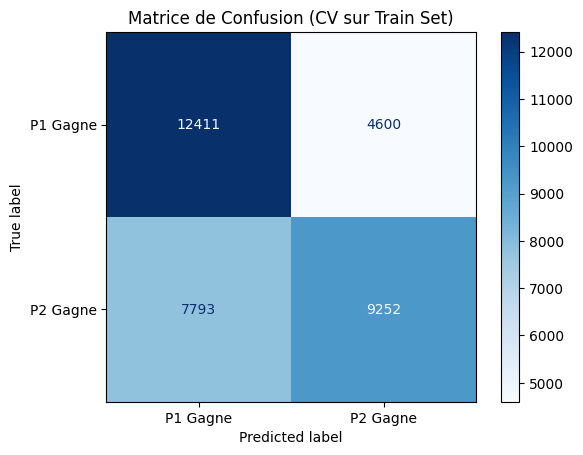

In [58]:
model = RandomForestClassifier(random_state=42)  # Ou un modèle optimisé
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

y_train_pred = np.zeros(len(y_train))  # Initialiser un tableau vide pour stocker les prédictions

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}/{n_splits}")

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(X_tr, y_tr)

    y_train_pred[test_index] = model.predict(X_val)

cm = confusion_matrix(y_train, y_train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['P1 Gagne', 'P2 Gagne'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion (CV sur Train Set)')
plt.show()



Text(70.72222222222221, 0.5, 'Vraie Classe')

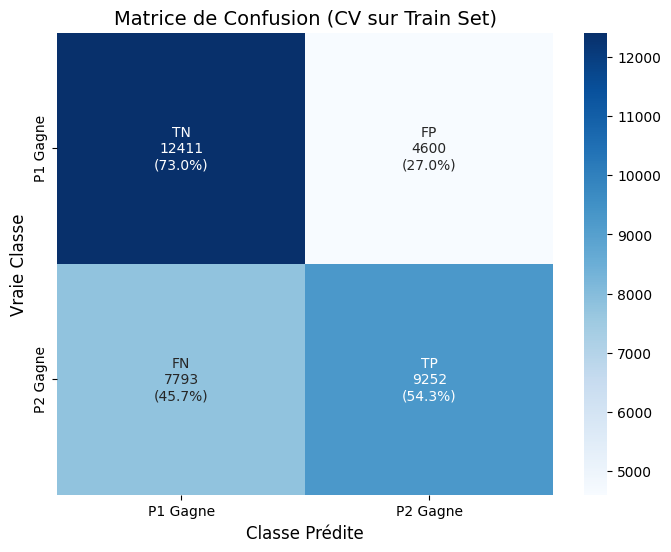

In [59]:
labels = np.array([["TN", "FP"],
                   ["FN", "TP"]])

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

cm_labels = np.array([[f"{labels[i, j]}\n{cm[i, j]}\n({cm_percentage[i, j]:.1f}%)"
                       for j in range(cm.shape[1])] for i in range(cm.shape[0])])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=cm_labels, fmt="", cmap="Blues", cbar=True,
            xticklabels=['P1 Gagne', 'P2 Gagne'],
            yticklabels=['P1 Gagne', 'P2 Gagne'])

plt.title('Matrice de Confusion (CV sur Train Set)', fontsize=14)
plt.xlabel('Classe Prédite', fontsize=12)
plt.ylabel('Vraie Classe', fontsize=12)


Number of prediction errors: 12393
Number of correct predictions: 21663


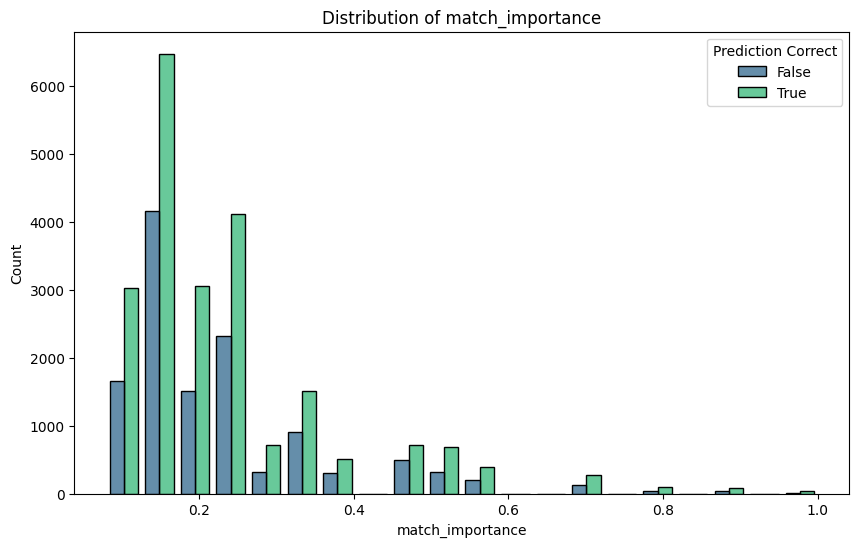

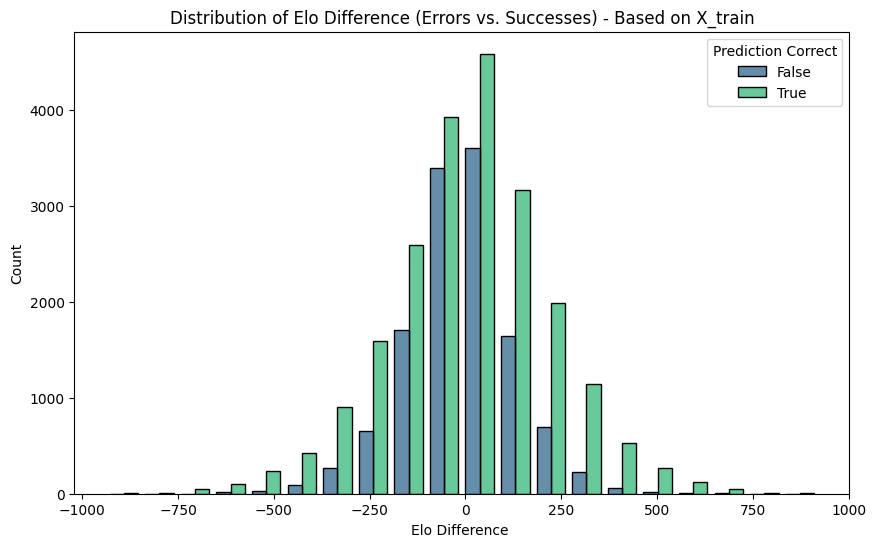

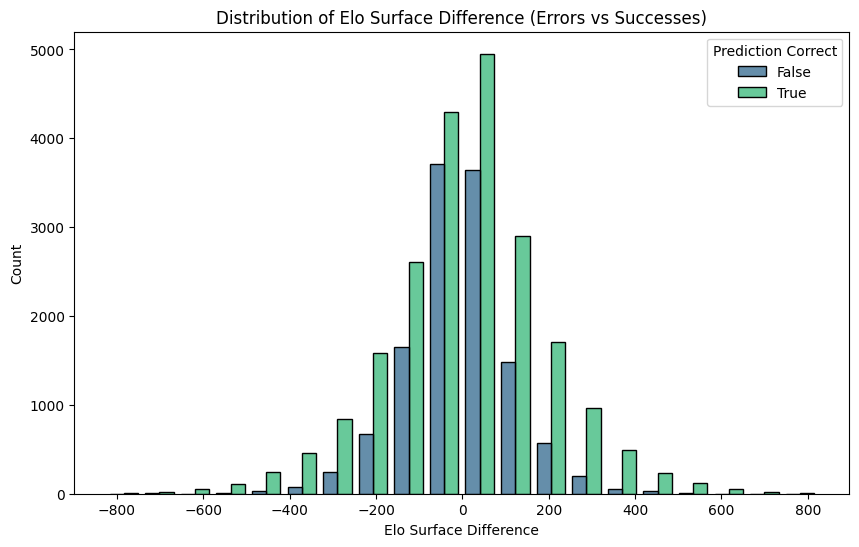

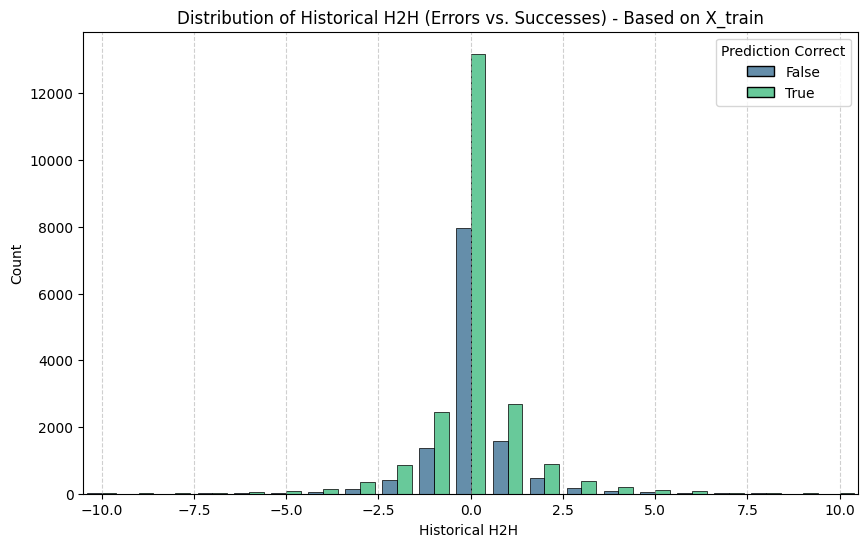

In [60]:
# Identify errors
errors_mask = (y_train_pred != y_train)
correct_mask = ~errors_mask

# Get indices where errors occurred
error_indices = y_train[errors_mask].index
correct_indices = y_train[correct_mask].index

# Select corresponding rows directly from X_train
# Ensure X_train has an index corresponding to y_train
error_matches = X_train.loc[error_indices].copy()
correct_matches = X_train.loc[correct_indices].copy()

print(f"Number of prediction errors: {len(error_matches)}")
print(f"Number of correct predictions: {len(correct_matches)}")

# Create a column indicating if the prediction was correct for plotting
X_train_analysis = X_train.copy() # Copy to avoid modifying the original
X_train_analysis['Prediction Correct'] = True # Use English name
X_train_analysis.loc[error_indices, 'Prediction Correct'] = False


# --- Analysis of Error Characteristics (Based on X_train) ---

# 1. Analyze by Match Importance
#    (Assuming 'match_importance' is a column in X_train)
if 'match_importance' in X_train_analysis.columns:
     plt.figure(figsize=(10, 6))
     # Use histplot with hue and multiple='dodge'
     sns.histplot(data=X_train_analysis, x='match_importance', hue='Prediction Correct',
                  multiple="dodge", shrink=0.8, palette='viridis', bins=20) # Use grouped bars
     plt.title('Distribution of match_importance') # Kept user's title
     plt.xlabel('match_importance')
     plt.ylabel('Count') # Display Count

# Analyze by elo difference
if 'elo_diff' in X_train_analysis.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=X_train_analysis, x='elo_diff', hue='Prediction Correct',
                 multiple="dodge", shrink=0.8, palette='viridis', bins=20) # Use grouped bars
    plt.title('Distribution of Elo Difference (Errors vs. Successes) - Based on X_train') # Translated title
    plt.xlabel('Elo Difference ') # Translated label
    plt.ylabel('Count') # Display Count

# Analyze by elo difference by surface
if 'elo_surface_diff' in X_train_analysis.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=X_train_analysis, x='elo_surface_diff', hue='Prediction Correct',
                 multiple="dodge", shrink=0.8, palette='viridis', bins=20) # Use grouped bars
    plt.title('Distribution of Elo Surface Difference (Errors vs Successes)') # Corrected user's title
    plt.xlabel('Elo Surface Difference') # Translated label
    plt.ylabel('Count') # Display Count


# 3. Analyze by H2H
#    (Assuming 'historical_h2h' is a column in X_train)
if 'historical_h2h' in X_train_analysis.columns:
    plt.figure(figsize=(10, 6)) # Slightly wider for H2H
    sns.histplot(data=X_train_analysis, x='historical_h2h', hue='Prediction Correct',
                 multiple='dodge', shrink=0.8, palette='viridis', discrete=True) # discrete=True to treat as categories
    plt.title('Distribution of Historical H2H (Errors vs. Successes) - Based on X_train') # Translated title
    plt.xlabel('Historical H2H ') # Translated label
    plt.ylabel('Count') # Display Count
    plt.xlim(-10.5, 10.5) # Kept user's xlim
    plt.grid(axis='x', linestyle='--', alpha=0.6) # Add vertical grid for readability

plt.show() # Single show command at the end, as in user's code

### Key Findings:

**Concentration of Errors:** The plots clearly indicates that incorrect predictions (represented by the blue bars) are significantly more concentrated around an Elo difference and a Head to Head close to zero. The highest frequency of errors occurs when the two players have very similar Elo ratings and a H2H really balanced.

**Model Strength:** Conversely, correct predictions (green bars) are more spread out across the range of Elo differences. While the model is also often correct when Elo ratings are similar, it demonstrates substantially better performance when there is a larger Elo difference, indicating a clearer skill gap between the opponents.

**Interpretation:** This finding highlights a common challenge in sports prediction: matches perceived as being closely contested (based on Elo ratings) are inherently harder to predict accurately. The model relies heavily on the Elo difference, and when this difference is minimal, its predictive power diminishes, leading to a higher error rate.

### Neural Network

Now let's see if a Dense neural network will have better performance that our Tree-based models.

For that let's create a Sequential Neural Network with 3 Dense Layers of 128, 64 and 32 neurones with a relu activation function.
Let's also add some Dropout to reduce overfitting.

In [42]:
train_length = int(len(dataset) * 0.8)
valid_length = int(len(dataset) * 0.1)
train_data = dataset[:train_length]
valid_data = dataset[train_length:train_length+valid_length]
test_data = dataset[train_length+valid_length:]


X_train = train_data.drop('winner', axis=1)
y_train = train_data['winner']
X_test = test_data.drop('winner', axis=1)
y_test = test_data['winner']
X_valid = valid_data.drop('winner', axis=1)
y_valid = valid_data['winner']

# Normalize the features
std_scaler = MinMaxScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_valid_std = std_scaler.transform(X_valid)
X_test_std = std_scaler.transform(X_test)

# Define a neural network with dropout to reduce overfitting
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')])

# Create an optimizer and a early_stopping callback
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_std, y_train, epochs=50, batch_size=128,
                    validation_data=(X_valid_std, y_valid), callbacks=[early_stopping])

model.evaluate(X_test_std, y_test)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


267/267 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.5119 - loss: 0.6955 - val_accuracy: 0.6342 - val_loss: 0.6736
Epoch 2/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5858 - loss: 0.6754 - val_accuracy: 0.6500 - val_loss: 0.6412
Epoch 3/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6192 - loss: 0.6521 - val_accuracy: 0.6509 - val_loss: 0.6232
Epoch 4/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6417 - loss: 0.6328 - val_accuracy: 0.6530 - val_loss: 0.6201
Epoch 5/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6493 - loss: 0.6293 - val_accuracy: 0.6547 - val_loss: 0.6188
Epoch 6/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6539 - loss: 0.6233 - val_accuracy: 0.6568 - val_loss: 0.6183
Epoch 7/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6578 - loss: 0.6196 - val_accuracy: 0.6556 - val_loss: 0.6179
Epoch 8/50
267/267 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6547 - loss: 0.6225 - val_accuracy: 0.6573 - val

[0.6216756105422974, 0.6470173597335815]

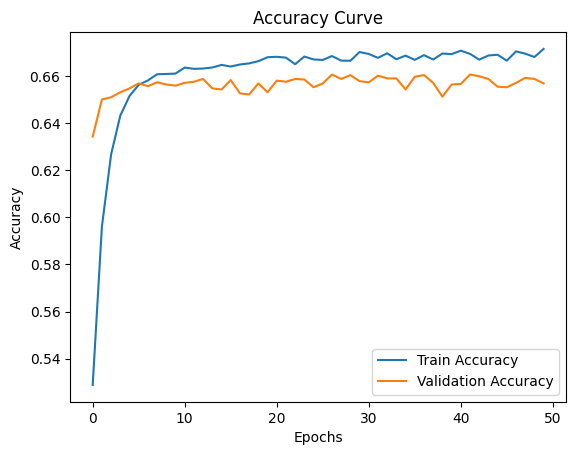

In [51]:
# Plot the accuracy curve
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

#### Neural Network (MLP) Results:

Our Neural Network model achieved a final accuracy of approximately 64.7% (with a binary cross-entropy loss of ~0.622). While demonstrating the feasibility of a deep learning approach, this initial result achieve a worst accuracy than our tree-based models in terms of raw accuracy for this specific feature set and architecture.